# Inception V3

### InceptionV3 with only 2 categories (Benign and Malign)

## Get packages

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A 
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Paths

In [2]:
TRAIN_PATH = 'archive/classification/binary/frame/aug/train'
TEST_PATH = 'archive/classification/binary/frame/aug/test' 
VALID_PATH = 'archive/classification/binary/frame/aug/validate'

In [3]:
input_size = (3,150,150)

## Load and Prepare Images

In [4]:

# # for neaug
# # divisible with 259: 7, 37
# train_batchsize = 37
# # divisible with 51: 3, 17 
# valid_batchsize = 3


#for aug
# divisible with 518:  2, 259.
train_batchsize = 2
# divisible with 51: 3, 17 
valid_batchsize = 3


# #for balance
# # divisible with 494: 2, 7, 14, 31, 62, 217
# train_batchsize = 7
# # divisible with 18: 2, 3, 6, 9
# valid_batchsize = 6

# # for neaug non-frame
# # divisible with 253: 11, 23 
# train_batchsize = 23
# # divisible with 50: 2, 5, 10, 25,
# valid_batchsize = 5


# #for aug non-frame
# # divisible with 506: 2, 11, 22, 23, 46, 253,
# train_batchsize = 22
# # divisible with 50: 2, 5, 10, 25,
# valid_batchsize = 5


# #for balance non-frame
# # divisible with 422: 2, 211.
# train_batchsize = 2
# # divisible with 16: 2, 4, 8,
# valid_batchsize = 4

train_datagen = ImageDataGenerator(
        rescale = 1./255.,

)

validation_datagen = ImageDataGenerator(
        rescale = 1./255.,
    )
                                  

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
         batch_size=train_batchsize,
        target_size = input_size[1:],
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size = input_size[1:],
        shuffle=True,
         batch_size=valid_batchsize,
        class_mode='categorical')

Found 518 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


## Make the model

### Pre-trained

In [11]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
 
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Add a final sigmoid layer with 1 node for classification output
model.add(Dense(2, activation='softmax'))
# Print a summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              18875392  
                                                                 
 activation_189 (Activation  (None, 1024)              0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2050      
                                                      

In [13]:
model.compile(

    loss=keras.losses.BinaryFocalCrossentropy(),
    optimizer=keras.optimizers.legacy.RMSprop(learning_rate=0.001,decay=1e-3, momentum=0.9),
    metrics = ['accuracy'])

## Train the model

In [14]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable) or tf.is_tensor(lr):
            lr = tf.keras.backend.get_value(lr)
        print(f" Epoch {epoch+1}: Learning rate is {lr:.6f}")

In [15]:
# Saving the best result
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_inception_binary_bun.h5', verbose=1, save_best_only=True)

steps = train_generator.samples//train_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)


callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
     reduce_lr,
    LearningRateLogger(),
    checkpoiter

]
# Train
results = model.fit(train_generator, 
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    steps_per_epoch = steps,
                    shuffle=True,
                    epochs=50, 
                    callbacks=callbacks,
                   )

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 92.8796 - accuracy: 0.7413 Epoch 1: Learning rate is 0.001000

Epoch 1: val_loss improved from inf to 58.68074, saving model to model_inception_binary_bun.h5
259/259 [==============================] - 29s 102ms/step - loss: 92.8796 - accuracy: 0.7413 - val_loss: 58.6807 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 83.0841 - accuracy: 0.7027 Epoch 2: Learning rate is 0.001000

Epoch 2: val_loss did not improve from 58.68074
259/259 [==============================] - 25s 95ms/step - loss: 83.0841 - accuracy: 0.7027 - val_loss: 94.4162 - val_accuracy: 0.2549 - lr: 0.0010
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 66.4615 - accuracy: 0.7124 Epoch 3: Learning rate is 0.001000

Epoch 3: val_loss did not improve from 58.68074
259/259 [==============================] - 25s 96ms/step - loss: 66.4615 - accuracy: 0.7124 - val_loss: 333.6785 

Epoch 24/50
259/259 [==============================] - ETA: 0s - loss: 1.4894 - accuracy: 0.8900 Epoch 24: Learning rate is 0.000010

Epoch 24: val_loss improved from 3.08723 to 2.77347, saving model to model_inception_binary_bun.h5
259/259 [==============================] - 26s 99ms/step - loss: 1.4894 - accuracy: 0.8900 - val_loss: 2.7735 - val_accuracy: 0.7647 - lr: 1.0000e-05
Epoch 25/50
259/259 [==============================] - ETA: 0s - loss: 1.4967 - accuracy: 0.8861 Epoch 25: Learning rate is 0.000010

Epoch 25: val_loss did not improve from 2.77347
259/259 [==============================] - 25s 98ms/step - loss: 1.4967 - accuracy: 0.8861 - val_loss: 3.2658 - val_accuracy: 0.8235 - lr: 1.0000e-05
Epoch 26/50
259/259 [==============================] - ETA: 0s - loss: 1.3957 - accuracy: 0.8784 Epoch 26: Learning rate is 0.000010

Epoch 26: val_loss did not improve from 2.77347
259/259 [==============================] - 26s 99ms/step - loss: 1.3957 - accuracy: 0.8784 - val_loss: 

## Results

In [16]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))

print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.8235294222831726
Loss Score =  2.4291625022888184


### During training

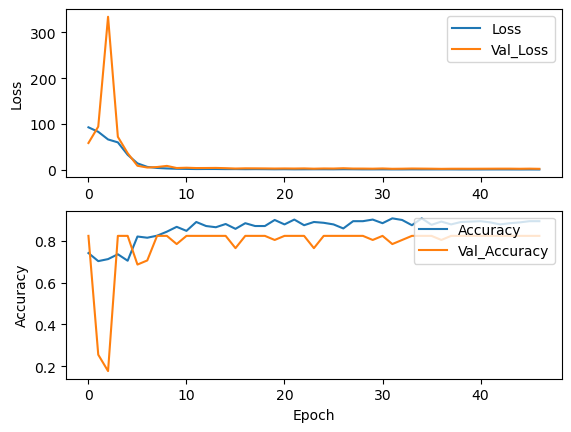

In [25]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Test the model

In [26]:

# divisible with 36: 2, 3, 4, 6, 9, 12, 18
test_batch_size = 1

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=input_size[1:],
    batch_size=test_batch_size,
    shuffle=False,
class_mode='categorical')

scores = model.evaluate(test_generator,workers=12)
print(scores)

Found 36 images belonging to 2 classes.
36/36 [==============================] - 1s 24ms/step - loss: 1.8967 - accuracy: 0.7778
[1.896666407585144, 0.7777777910232544]


### Make predictions

In [27]:
test_generator.reset()

Y_pred = model.predict(test_generator, verbose=1)

y_pred = np.argmax(Y_pred, axis=-1)
classes = test_generator.classes

print(classes)
print(y_pred)

print(sum(y_pred==classes)/len(test_generator.classes))
target_names = list(test_generator.class_indices.keys())

36/36 [==============================] - 1s 22ms/step
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.7777777777777778


### Confusion Matrix

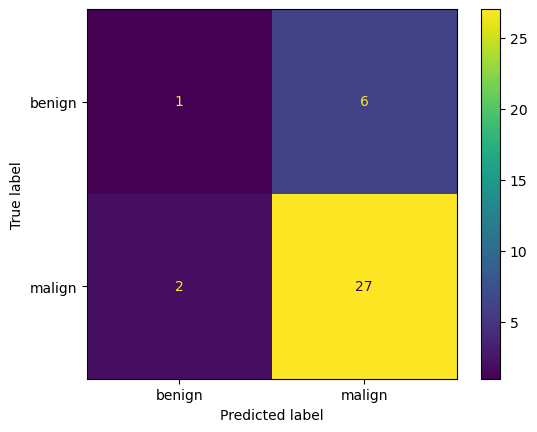

In [20]:
# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot()
plt.grid(False)
plt.show()

In [21]:
TN, FP, FN, TP = cm.ravel()

In [22]:
print("True positive=",TP)
print("True Negative=",TN)
print("False positive=",FP)
print("False Negative=",FN)

True positive= 27
True Negative= 1
False positive= 6
False Negative= 2


In [23]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
#F1_SCORE
FSCO=(2*TP) / ((2*TP) +FP + FN) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [24]:
print("sensitivity=",TPR*100,"%")
print("precision=",PPV*100,"%")
print("Specificity=",TNR*100,"%")
print("F-score=",FSCO*100,"%")
print("ACCURACY=",ACC*100,"%")
print("FNR=",FNR*100,"%")
print("FPR=",FPR*100,"%")
print("NPV=",NPV*100,"%")

sensitivity= 93.10344827586206 %
precision= 81.81818181818183 %
Specificity= 14.285714285714285 %
F-score= 87.09677419354838 %
ACCURACY= 77.77777777777779 %
FNR= 6.896551724137931 %
FPR= 85.71428571428571 %
NPV= 33.33333333333333 %
